In [1]:
%load_ext autoreload
%autoreload 2

In [117]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml

In [3]:
device = "cuda:7"

In [4]:
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
You should 

In [10]:
prompt_config = PromptConfig(dataset_name)
dataset = PromptDataset(prompt_config, split="train")

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 400.68it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


In [11]:
s = set()
for i in range(len(dataset)):
    s.add(dataset[i][0].label)

In [31]:
dataset[0][0].to_string(0)

'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nBusiness'

In [48]:
d00 = dataset[0][0]

In [49]:
d01 = dataset[0][0]

In [50]:
d00 == d01

False

In [51]:
d00

Prompt(prefix='', template=<elk.promptsource.templates.Template object at 0x7fca833af7c0>, example={'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.', 'label': 0}, label=0, label_column='label')

In [52]:
d01

Prompt(prefix='', template=<elk.promptsource.templates.Template object at 0x7fca833ae920>, example={'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.', 'label': 0}, label=0, label_column='label')

In [33]:
template = dataset[0][0].template

In [43]:
template.apply(dataset[0][0].example)

['What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.',
 '\nWorld politics']

In [76]:
def dsget(dataset, i):
    dsi = dataset[i][0]
    true, false = list(dsi.to_string(answer_idx) for answer_idx in range(2))
    if dsi.label == 1:
        return (false, true)
    return (true, false)

In [88]:
dsget(dataset, 0)

('What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nWorld politics',
 'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nScience and technology')

In [89]:
RPATH = "/fsx/home-rudolf/elk-reporters"

def load_config(name, rpath=RPATH):
    """Loads yaml config from RPATH/[name]/cfg.yaml"""
    with open(os.path.join(rpath, name, "cfg.yaml"), "r") as f:
        return yaml.safe_load(f)

In [90]:
load_config("friendly-montalcini")

FileNotFoundError: [Errno 2] No such file or directory: '/fsx/home-rudolf/elk-reporters/friendly-montalcini/cfg.yaml'

In [91]:
def get_relevant_runs(reqs, rpath=RPATH):
    """Requirements is a dictionary of the form:
    property specification, e.g. "data.prompts.dataset"
    --->
    required value"""
    valid_reporters = []
    for name in os.listdir(rpath):
        cfg = load_config(name, rpath)
        add = True
        for prop, reqval in reqs.items():
            prop_parts = prop.split(".")
            temp = cfg
            for next_level in prop_parts:
                if next_level in temp.keys():
                    temp = temp[next_level]
                else:
                    add = False
                    break
            if temp != reqval:
                add = False
                break
        if add:
            valid_reporters.append(name)
    return valid_reporters

def get_eval(run_name):
    return pd.read_csv(os.path.join(RPATH, run_name, "eval.csv"))

def graph_eval(run_name):
    eval = get_eval(run_name)
    fig, ax = plt.subplots()
    ax.scatter(eval["layer"], eval["acc"], label="acc")
    ax.scatter(eval["layer"], eval["lr_acc"], label="LR acc")
    ax.legend()
    ax.set_title(f"{load_config(run_name)['data']['model']} on {load_config(run_name)['data']['prompts']['dataset']}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    fig.show()

def num_from_str(s):
    """Strip all non-numeric characters from s and interpret as a number"""
    num_str = ''
    for char in s:
        if char.isdigit():
            num_str += char
    if num_str == '':
        return None
    else:
        return int(num_str)

def get_reporters(run_name):
    r_dict = {
        layer_number : t.load(os.path.join(RPATH, run_name, "reporters", layer_name)).to(device)
        for (layer_number, layer_name) in [
            (num_from_str(layer_name), layer_name)
            for layer_name in os.listdir(os.path.join(RPATH, run_name, "reporters"))
            ]
        }
    return [r_dict[i] for i in range(len(r_dict))]

In [92]:
runs = get_relevant_runs(
    {
        "data.prompts.dataset": dataset_name,
        "net.net_name": "ccs",
        "data.model": model_name
    }
)

In [93]:
runs

['objective-ritchie',
 'unruffled-babbage',
 'strange-johnson',
 'competent-curie',
 'vibrant-fermi',
 'serene-jang']

In [94]:
run = runs[-1]

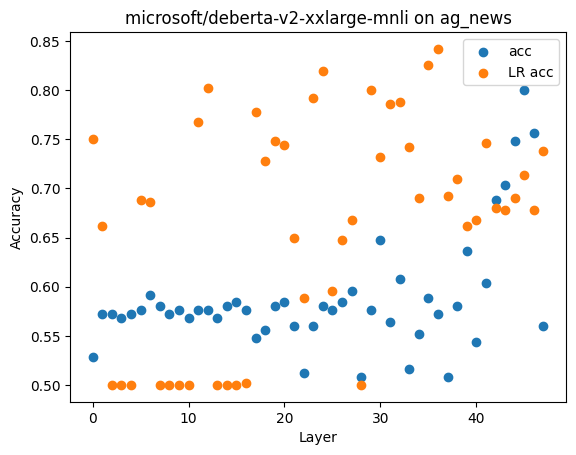

In [95]:
graph_eval(run)

In [96]:
reporters = get_reporters(run)

In [97]:
reporters[0]

CcsReporter(
  (probe): Sequential(
    (0): Linear(in_features=1536, out_features=1, bias=True)
  )
)

In [104]:
def reporter_outputs(reporters, sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    outo = model(inputs["input_ids"], output_hidden_states=True)
    # the +1 in i+1 is because the first hidden state is the input embedding
    return t.stack([r(outo[1][i+1])[0] for i, r in enumerate(reporters)], dim=0)

def reporter_output(reporter, sentence):
    return reporter_outputs([reporter], sentence)[0]

def plot_2d_tensor_as_heatmap(t2d):
    fig, ax = plt.subplots()
    heatmap = ax.imshow(t2d.cpu().detach().numpy(), cmap="hot", interpolation="nearest")
    ax.set_xlabel("Token")
    ax.set_ylabel("Reporter (=layer)")
    plt.colorbar(heatmap)

def best_reporter(run_name):
    layer_eval = get_eval(run_name)
    # find the row in the pandas dataframe layer_eval with the highest accuracy:
    best_layer = layer_eval["layer"][layer_eval["acc"].idxmax()]
    reporter = get_reporters(run_name)[best_layer]
    return reporter

def best_layer_output(run_name, sentence):
    reporter = best_reporter(run_name)
    return reporter_outputs([reporter], sentence)[0]

In [103]:
best_layer_output(run, "Is 1+1=2? Yes")

tensor([-0.4311, -0.3070, -0.6290, -0.9326, -0.9251, -0.5465, -1.0682, -0.6535,
        -0.3852], device='cuda:7', grad_fn=<SelectBackward0>)

In [79]:
r_outs = reporter_outputs(reporters, "Is 1 + 1 = 2? No")

In [80]:
r_outs.shape

torch.Size([48, 11])

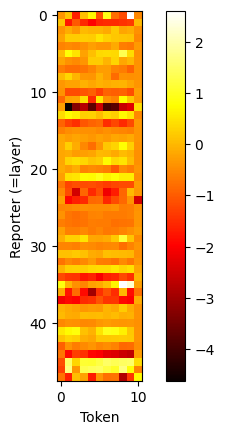

In [81]:
plot_2d_tensor_as_heatmap(r_outs)

## Sanity test for reporter

In [122]:
def plot_ccs_pairs(reporter, dataset, num_examples=10):
    true_activations = []
    false_activations = []
    for _ in range(num_examples):
        (true, false) = dsget(dataset, i)
        true_activations.append(reporter_output(reporter, true).cpu().detach().numpy())
        false_activations.append(reporter_output(reporter, false).cpu().detach().numpy())
    fig, ax = plt.subplots()
    for x in true_activations:
        ax.plot(np.linspace(0, 1, x.shape[0]), x, color="green", alpha=0.2)
    for x in false_activations:
        ax.plot(np.linspace(0, 1, x.shape[0]), x, color="red", alpha=0.2)
    fig.show()

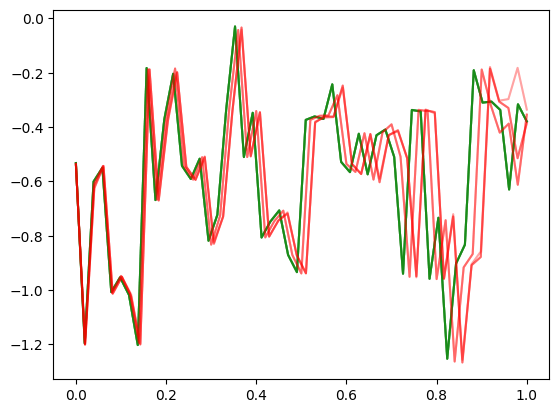

In [123]:
plot_ccs_pairs(best_reporter(run), dataset)